In [1]:
import pandas as pd
import numpy as np
from setuptools.build_meta import prepare_metadata_for_build_editable
from tensorflow import config
from tensorflow.keras import utils, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Dropout
from tensorflow.keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
gpus = config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        config.experimental.set_visible_devices(gpus[0], 'GPU')
        config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
df = pd.read_csv('Conversation.csv')
questions = df['question'].astype('str').tolist()
answers = df['answer'].astype('str').tolist()
questions, val_questions, answers, val_answers = train_test_split(questions, answers, test_size=0.2)
def loss_plot(history_):
    loss     = history_.history['loss']
    val_loss = history_.history['val_loss']
    epochs   = range(len(loss))
    plt.figure()
    plt.plot  ( epochs,loss )
    plt.plot  ( epochs,val_loss )
    plt.title ('Training and validation loss')
def acc_plot(history_):
    acc = history_.history['accuracy']
    val_acc  = history_.history[ 'val_accuracy' ]
    epochs   = range(len(acc))
    plt.figure()
    plt.plot  ( epochs,     acc )
    plt.plot  ( epochs, val_acc )
    plt.title ('Training and validation accuracy')

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
question_sequences = tokenizer.texts_to_sequences(questions)
answer_sequences = tokenizer.texts_to_sequences(answers)
question_len = max(len(seq) for seq in question_sequences)
answer_len = max(len(seq) for seq in answer_sequences)
question_sequences = pad_sequences(question_sequences, maxlen=question_len, padding='post')
answer_sequences = pad_sequences(answer_sequences, maxlen=answer_len, padding='post')
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index
print(questions[0].split())
print(question_sequences[0])
print(vocab_size)

['a', 'button', 'came', 'off', 'my', 'shirt.']
[  5 621 414 126  19 518   0   0   0   0   0   0   0   0   0   0   0   0
   0]
{'i': 1, 'you': 2, 'the': 3, 'to': 4, 'a': 5, 'it': 6, 'that': 7, 'do': 8, 'what': 9, 'is': 10, 'of': 11, 'and': 12, 'have': 13, 'are': 14, 'in': 15, "it's": 16, 'so': 17, 'they': 18, 'my': 19, 'was': 20, 'did': 21, 'like': 22, "don't": 23, 'but': 24, 'he': 25, 'for': 26, 'yes': 27, 'no': 28, 'me': 29, "i'm": 30, 'be': 31, "that's": 32, 'we': 33, 'about': 34, 'on': 35, 'how': 36, 'not': 37, 'go': 38, 'why': 39, 'too': 40, 'your': 41, 'think': 42, 'going': 43, 'good': 44, 'will': 45, 'with': 46, 'want': 47, 'all': 48, 'get': 49, 'know': 50, 'well': 51, 'at': 52, 'really': 53, "i'll": 54, 'one': 55, 'just': 56, 'there': 57, 'would': 58, 'can': 59, 'this': 60, 'if': 61, "you're": 62, 'then': 63, 'see': 64, 'right': 65, 'people': 66, 'she': 67, "what's": 68, "didn't": 69, 'oh': 70, 'should': 71, 'money': 72, 'need': 73, 'out': 74, 'nice': 75, 'her': 76, 'time': 77, 

In [11]:
val_tokenizer = Tokenizer()
val_tokenizer.fit_on_texts(val_questions + val_answers)
val_question_sequences = val_tokenizer.texts_to_sequences(val_questions)
val_answer_sequences = val_tokenizer.texts_to_sequences(val_answers)
val_question_len = max(len(seq) for seq in val_question_sequences)
val_answer_len = max(len(seq) for seq in val_answer_sequences)
val_question_sequences = pad_sequences(val_question_sequences, maxlen=19, padding='post')
val_answer_sequences = pad_sequences(val_answer_sequences, maxlen=19, padding='post')
print(val_questions[0].split())
print(val_question_sequences[0])
print(len(val_tokenizer.word_index) + 1)

["we've", 'already', 'voted', 'for', 'new', 'taxes', 'to', 'pay', 'for', 'all', 'that', 'stuff!']
[552 273 828  21  76 407   4 408  21  58   8 553   0   0   0   0   0   0
   0]
1495


In [4]:
answers_one_hot = utils.to_categorical(answer_sequences, num_classes=vocab_size)
val_answers_one_hot = utils.to_categorical(val_answer_sequences, num_classes=vocab_size)

In [5]:
model = Sequential([
          Embedding(vocab_size, 200, input_length=question_len),
          Bidirectional(LSTM(100, return_sequences=True)),
          Bidirectional(LSTM(50, return_sequences=True)),
          Dense(vocab_size, activation='softmax')
])
optimizer = Adam(learning_rate=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                                     factor=0.5, 
                                                     patience=2, 
                                                     min_lr=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(question_sequences, answers_one_hot, epochs=100, validation_data=(val_question_sequences,val_answers_one_hot),  verbose=2, callbacks=[lr_scheduler])

Epoch 1/100
94/94 - 12s - loss: 3.7529 - accuracy: 0.6485 - val_loss: 2.5006 - val_accuracy: 0.6567 - lr: 0.0010 - 12s/epoch - 126ms/step
Epoch 2/100
94/94 - 2s - loss: 2.4447 - accuracy: 0.6554 - val_loss: 2.3832 - val_accuracy: 0.6567 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 3/100
94/94 - 2s - loss: 2.3674 - accuracy: 0.6572 - val_loss: 2.3666 - val_accuracy: 0.6667 - lr: 0.0010 - 2s/epoch - 19ms/step
Epoch 4/100
94/94 - 2s - loss: 2.3270 - accuracy: 0.6641 - val_loss: 2.3618 - val_accuracy: 0.6667 - lr: 0.0010 - 2s/epoch - 20ms/step
Epoch 5/100
94/94 - 2s - loss: 2.2933 - accuracy: 0.6650 - val_loss: 2.3713 - val_accuracy: 0.6666 - lr: 0.0010 - 2s/epoch - 21ms/step
Epoch 6/100
94/94 - 2s - loss: 2.2745 - accuracy: 0.6648 - val_loss: 2.3787 - val_accuracy: 0.6669 - lr: 0.0010 - 2s/epoch - 22ms/step
Epoch 7/100
94/94 - 2s - loss: 2.2406 - accuracy: 0.6652 - val_loss: 2.4072 - val_accuracy: 0.6667 - lr: 5.0000e-04 - 2s/epoch - 23ms/step
Epoch 8/100
94/94 - 2s - loss: 2.2290 - accuracy

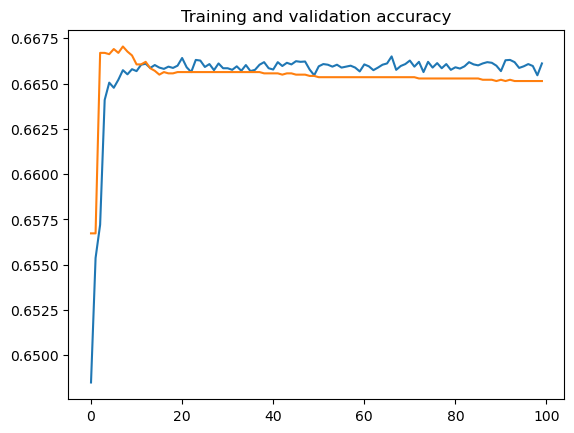

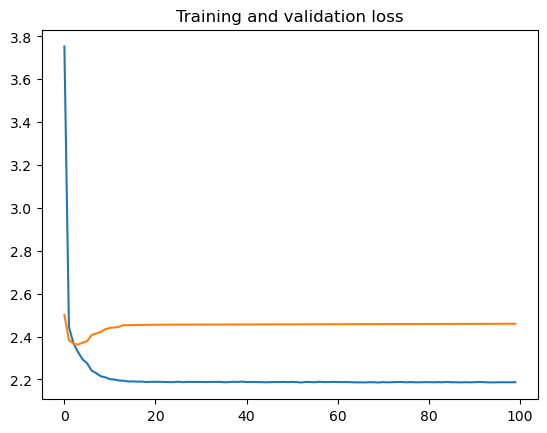

In [6]:
acc_plot(history)
loss_plot(history)

In [14]:
def predict_answer(question_, max_len, answer_max_len):
    question_sequence = tokenizer.texts_to_sequences([question_.lower()])[0]
    question_sequence = pad_sequences([question_sequence], maxlen=max_len, padding='post')
    prediction = model.predict(question_sequence)
    predicted_indices = np.argmax(prediction, axis=-1)[0]
    predicted_answer = ' '.join([tokenizer.index_word.get(idx, '<unk>') for idx in predicted_indices if idx > 0])
    return predicted_answer
for i in range(10):
    question = questions[i]
    answer = predict_answer(question, question_len, answer_len)
    print(f"Question: {question}")
    print(f"Answer: {answer}")

1/1 [==============================] - 0s 29ms/step
Question: a button came off my shirt.
Answer: i i you you
1/1 [==============================] - 0s 30ms/step
Question: you have a lot of plants.
Answer: i i
1/1 [==============================] - 0s 34ms/step
Question: no. that will cost too much money.
Answer: i i you
1/1 [==============================] - 0s 33ms/step
Question: did you need something?
Answer: i i you
1/1 [==============================] - 0s 40ms/step
Question: do they talk about us?
Answer: i i
1/1 [==============================] - 0s 36ms/step
Question: okay. it looks like rain.
Answer: i i you
1/1 [==============================] - 0s 38ms/step
Question: i really wish i went to the game.
Answer: i i you
1/1 [==============================] - 0s 36ms/step
Question: i have no idea. all of a sudden i heard your siren.
Answer: i i
1/1 [==============================] - 0s 39ms/step
Question: how do they do that?
Answer: i i you
1/1 [==============================] 